# Machine Learning on gut microbiota of patients with Colorectal cancer (9): Predictive Model using Random Forest

Random Forest, a ensemble machine learning algorithm with multiple decision trees could be used for classification or regression algorithm, and it has an elegant way of dealing with nonlinear or linear data.
> Random forest aims to reduce the previously mentioned correlation issue by choosing only a subsample of the feature space at each split. Essentially, it aims to make the trees de-correlated and prune the trees by setting a stopping criteria for node splits, which I will cover in more detail later.


## Important Parameters

+ **number of estimators**: the number of trees for constructing forest.
+ **max depth of each tree**: the number of features per decision tree.
+ **max features per split**: it affects the performance of the whole dicision tree.

**estimator** also termed tree and depth control the complexity of the model, with larger *estimators* would result in better and high density forest and maximum depth helps fighting with overfitting.

`Random Forest doesn't require careful preprocessing such as normalization of data`. Standardization is an important requirement for many classification models that should be handled when implementing pre-processing. Some models (like neural networks) can perform poorly if pre-processing isn't considered, so the `describe()` function is a good indicator for standardization. Fortunately, random forest does not require any pre-processing.

## Loading libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import time
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split

import seaborn as sns
#plt.style.use('fivethirtyeight')
plt.style.use('fivethirtyeight')
sns.set_style("darkgrid")

plt.rcParams['figure.figsize'] = (8, 4)

## Importing data

In [2]:
'''
# raw data
data_df = pd.read_table('./dataset/MergeData.tsv', sep="\t", index_col=0)
data = data_df.reset_index(drop=True)
data.head()

# significant species
data_df = pd.read_table('./dataset/MergeData_clr_signif.tsv', sep="\t", index_col=0)
data = data_df.reset_index(drop=True)
data.head()
'''

# CLR-transformed data
data_df = pd.read_table('./dataset/MergeData_clr.tsv', sep="\t", index_col=0)
data = data_df.reset_index(drop=True)
data.head()

disease  s__Bacteroides_plebeius  s__Bacteroides_dorei  \
0  healthy                10.262146              8.532694   
1  healthy                 7.609333              4.466872   
2  healthy                 8.411267              7.884081   
3  healthy                 6.261269              6.939669   
4      CRC                -0.026692              5.697435   

   s__Faecalibacterium_prausnitzii  s__Eubacterium_eligens  \
0                         7.729839                7.605931   
1                         6.654823                4.236672   
2                         7.668467               -3.379905   
3                         5.819509                4.064784   
4                         3.808831                4.253082   

   s__Bacteroides_ovatus  s__Parabacteroides_distasonis  \
0               7.477464                       7.267232   
1               4.697277                       3.518645   
2               6.577229                       6.474488   
3               4.026179                       7.227381   
4               4.284986                       5.784833   

   s__Ruminococcus_gnavus  s__Phascolarctobacterium_faecium  \
0                7.074996                          6.832596   
1                2.603642                         -3.929140   
2                6.883446                         -3.379905   
3                3.407265                         -3.632294   
4                6.384592                         -5.007660   

   s__Bacteroides_uniformis  ...  s__Bacteroides_finegoldii  \
0                  6.738413  ...                  -3.441779   
1                  5.619399  ...                  -3.929140   
2                  6.725545  ...                  -3.379905   
3                  6.170285  ...                  -3.632294   
4                  5.492187  ...                   4.187313   

   s__Haemophilus_sp_HMSC71H05  s__Clostridium_saccharolyticum  \
0                    -3.441779                       -3.441779   
1                    -3.929140                       -3.929140   
2                    -3.379905                       -3.379905   
3                    -3.632294                       -3.632294   
4                     2.872359                        2.219946   

   s__Streptococcus_anginosus_group  s__Streptococcus_sp_A12  \
0                         -3.441779                -3.441779   
1                         -3.929140                -3.929140   
2                         -3.379905                -3.379905   
3                         -3.632294                -3.632294   
4                          0.713786                -5.007660   

   s__Klebsiella_pneumoniae  s__Bacteroides_coprocola  \
0                 -3.441779                 -3.441779   
1                 -3.929140                 -3.929140   
2                 -3.379905                 -3.379905   
3                 -3.632294                 -3.632294   
4                 -5.007660                 -5.007660   

   s__Ruminococcus_lactaris  s__Turicimonas_muris  \
0                 -3.441779             -3.441779   
1                 -3.929140             -3.929140   
2                 -3.379905             -3.379905   
3                 -3.632294             -3.632294   
4                 -5.007660             -5.007660   

   s__Proteobacteria_bacterium_CAG_139  
0                            -3.441779  
1                            -3.929140  
2                            -3.379905  
3                            -3.632294  
4                            -5.007660  

[5 rows x 152 columns]

## Missing values or Occurrence

the occurrence per features

In [4]:
#data.iloc[:, 1:].apply(lambda x: np.count_nonzero(x)/len(x), axis=0)

In [4]:
print("Here's the dimensions of our data frame:\n", data.shape)
print("Here's the data types of our columns:\n", data.dtypes)

Here's the dimensions of our data frame:
 (504, 152)
Here's the data types of our columns:
 disease                                 object
s__Bacteroides_plebeius                float64
s__Bacteroides_dorei                   float64
s__Faecalibacterium_prausnitzii        float64
s__Eubacterium_eligens                 float64
                                        ...   
s__Klebsiella_pneumoniae               float64
s__Bacteroides_coprocola               float64
s__Ruminococcus_lactaris               float64
s__Turicimonas_muris                   float64
s__Proteobacteria_bacterium_CAG_139    float64
Length: 152, dtype: object


In [5]:
data.describe()

s__Bacteroides_plebeius  s__Bacteroides_dorei  \
count               504.000000            504.000000   
mean                  1.256825              2.927299   
std                   5.247064              4.821565   
min                  -5.286399             -4.671094   
25%                  -3.319519             -2.510933   
50%                  -2.118272              4.413118   
75%                   6.963744              7.264553   
max                  11.092608             11.372814   

       s__Faecalibacterium_prausnitzii  s__Eubacterium_eligens  \
count                       504.000000              504.000000   
mean                          5.667281                1.616724   
std                           2.990958                4.504301   
min                          -3.893930               -4.943353   
25%                           5.642812               -2.901603   
50%                           6.563336                2.013259   
75%                           7.317980                6.046958   
max                          10.350223               10.790908   

       s__Bacteroides_ovatus  s__Parabacteroides_distasonis  \
count             504.000000                     504.000000   
mean                3.307470                       4.681808   
std                 3.605593                       3.569784   
min                -4.341294                      -4.135735   
25%                 1.786175                       4.290055   
50%                 4.218514                       5.628107   
75%                 5.716982                       6.921791   
max                10.995056                      10.776272   

       s__Ruminococcus_gnavus  s__Phascolarctobacterium_faecium  \
count              504.000000                        504.000000   
mean                 3.345991                         -0.456599   
std                  3.994830                          3.804094   
min                 -4.746337                         -5.286399   
25%                  0.991982                         -3.455534   
50%                  4.270669                         -2.534482   
75%                  6.315415                          3.635188   
max                 10.795287                          7.801161   

       s__Bacteroides_uniformis  s__Bifidobacterium_longum  ...  \
count                504.000000                 504.000000  ...   
mean                   6.187024                   2.897217  ...   
std                    2.888385                   3.702841  ...   
min                   -3.742171                  -4.520503  ...   
25%                    5.611716                   0.599582  ...   
50%                    6.872015                   4.003185  ...   
75%                    7.934838                   5.439522  ...   
max                   10.596756                  11.050896  ...   

       s__Bacteroides_finegoldii  s__Haemophilus_sp_HMSC71H05  \
count                 504.000000                   504.000000   
mean                   -1.050304                    -2.053572   
std                     3.734545                     2.382407   
min                    -5.061605                    -4.993406   
25%                    -3.503629                    -3.597303   
50%                    -2.903888                    -2.991046   
75%                     0.770320                    -1.707308   
max                     9.794324                     7.783317   

       s__Clostridium_saccharolyticum  s__Streptococcus_anginosus_group  \
count                      504.000000                        504.000000   
mean                        -1.841538                         -1.708054   
std                          2.704140                          2.416765   
min                         -5.286399                         -4.993406   
25%                         -3.602112                         -3.403795   
50%                         -2.946014                         -2.678076   
75%                 

## Class balance

Displaying the counts by values and plot

In [6]:
def print_rate(data_frame, col):
    try:
        col_vals = data_frame[col].value_counts()
        col_vals = col_vals.reset_index()
        if len(col_vals['index']) > 20:
            print('Warning: values in column are more than 20 \nPlease try a column with lower value counts!')
        else:
            f = lambda x, y: 100 * (x / sum(y))
            for i in range(0, len(col_vals['index'])):
                print('{0} accounts for {1:.2f}% of the {2} column'\
                      .format(col_vals['index'][i], f(col_vals[col].iloc[i], col_vals[col]), col))
    except KeyError as e:
        print('{0}: Not found'.format(e))
        print('Please choose the right column name!')

print_rate(data, 'disease')

CRC accounts for 51.19% of the disease column
healthy accounts for 48.81% of the disease column


[Text(0, 0, '246'), Text(0, 0, '258')]

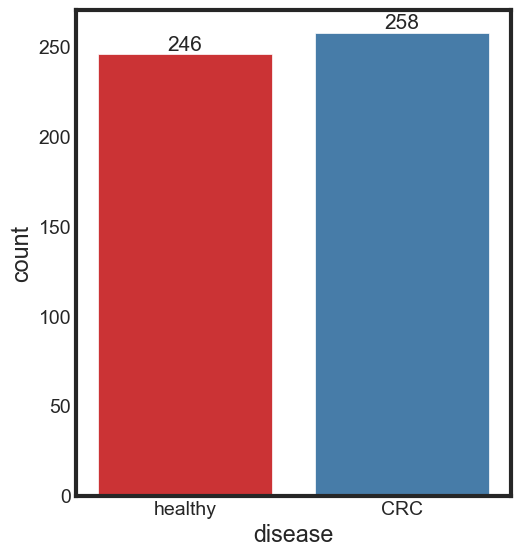

In [8]:
sns.set_style("white")
sns.set_context({"figure.figsize": (5, 6)})
ax = sns.countplot(x = 'disease', data = data, label = "Count", palette = "Set1")
ax.bar_label(ax.containers[0], fontsize=15)

## Distribution of features

Taking a look at the distribution of each feature and see how they are different between 'healthy' and 'CRC'. To see the distribution of multiple variables, using violin plot, swarm plot or box plot.

Here, we choose 10 features to visualization

+ standardizing data and gathering data into long data 

In [9]:
from sklearn.preprocessing import StandardScaler


df_features = data.iloc[:, 1:]

scaler = StandardScaler()
scaler.fit(df_features)

features_scaled = scaler.transform(df_features)
features_scaled = pd.DataFrame(data=features_scaled,
                               columns=df_features.columns)

data_scaled = pd.concat([features_scaled, data['disease']], axis=1)

data_scaled_melt = pd.melt(data_scaled, id_vars='disease', var_name='features', value_name='value')
data_scaled_melt.head(10)

disease                 features     value
0  healthy  s__Bacteroides_plebeius  1.717964
1  healthy  s__Bacteroides_plebeius  1.211882
2  healthy  s__Bacteroides_plebeius  1.364868
3  healthy  s__Bacteroides_plebeius  0.954709
4      CRC  s__Bacteroides_plebeius -0.244859
5      CRC  s__Bacteroides_plebeius -0.364734
6      CRC  s__Bacteroides_plebeius  0.002748
7      CRC  s__Bacteroides_plebeius  1.222586
8      CRC  s__Bacteroides_plebeius  0.547317
9      CRC  s__Bacteroides_plebeius -1.182821

+ violin plot

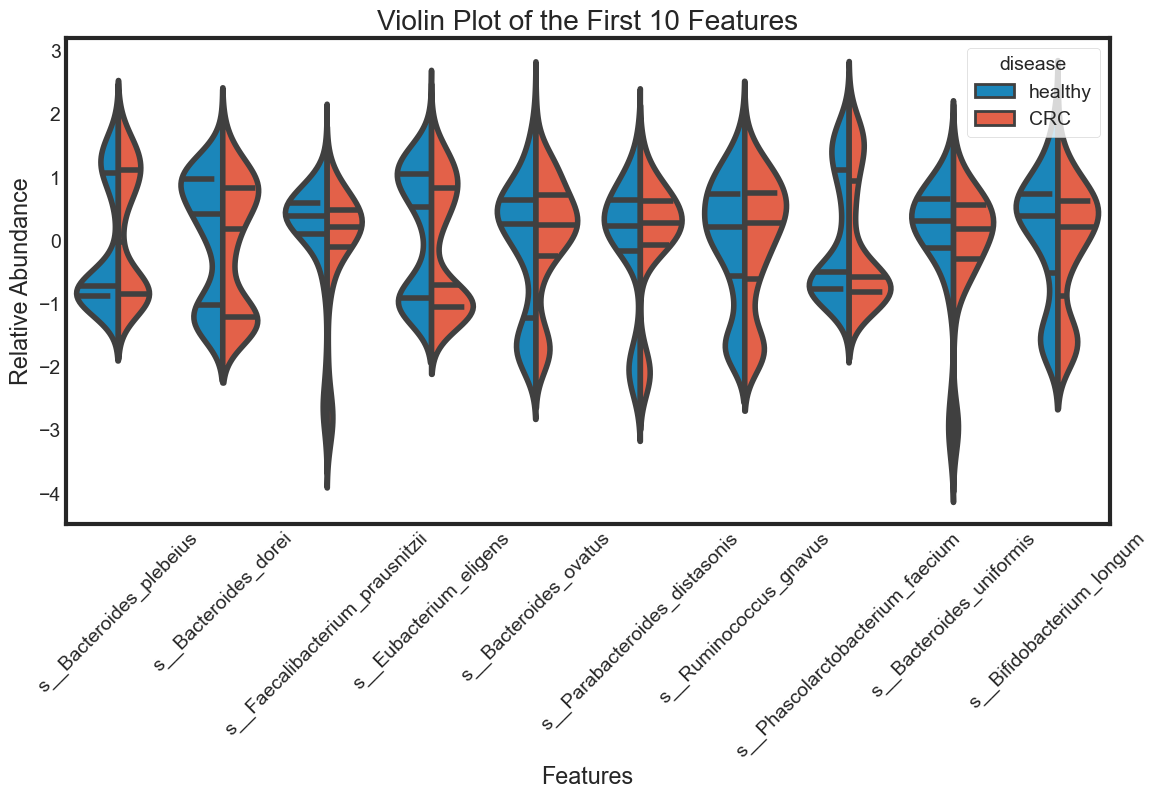

In [10]:
def violin_plot(features, name):
    """
    This function creates violin plots of features given in the argument.
    """
    # Create query
    query = ''
    for x in features:
        query += "features == '" + str(x) + "' or "
    query = query[0: -4]

    # Create data for visualization
    plotdata = data_scaled_melt.query(query)

    # Plot figure
    plt.figure(figsize=(12, 6))
    sns.violinplot(x='features',
                   y='value',
                   hue='disease',
                   data=plotdata,
                   split=True,
                   inner="quart")
    plt.xticks(rotation=45)
    plt.title(name)
    plt.xlabel("Features")
    plt.ylabel("Relative Abundance")


violin_plot(data.columns[1:11], "Violin Plot of the First 10 Features")

+ swarm plot

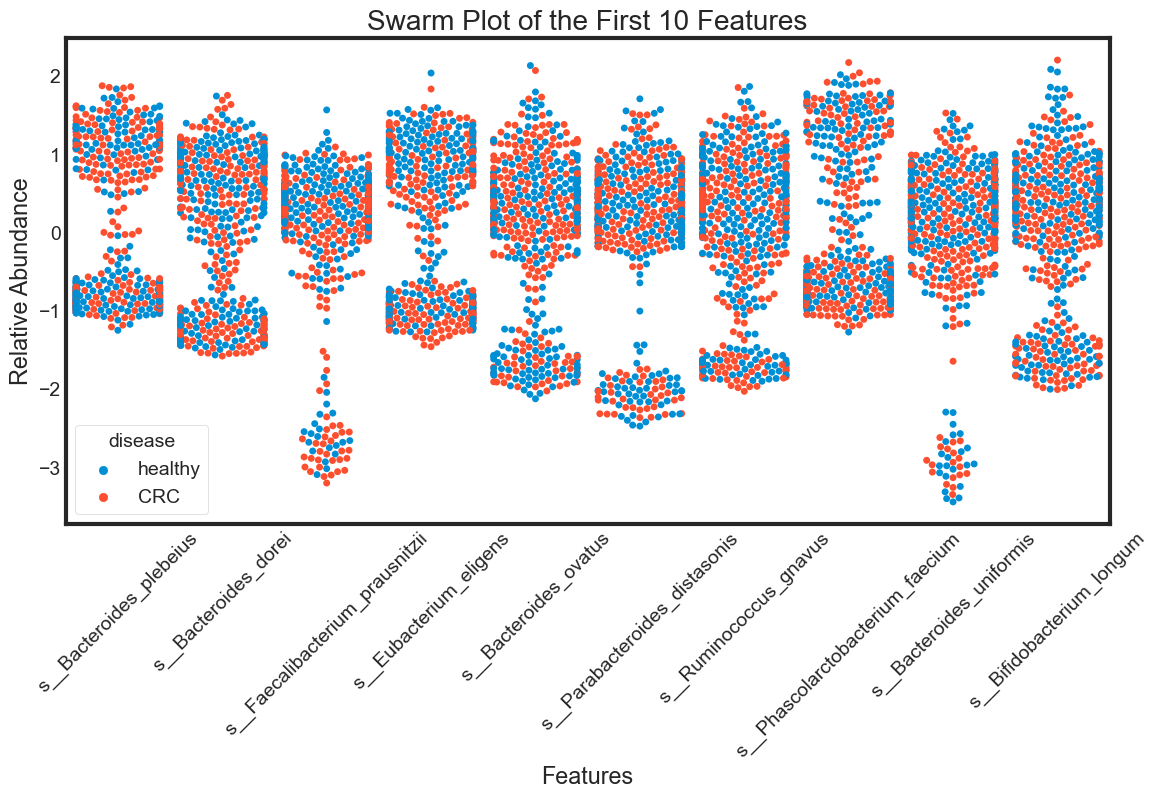

In [11]:
%%capture --no-display

def swarm_plot(features, name):
    """
    This function creates swarm plots of features given in the argument.
    """
    # Create query
    query = ''
    for x in features:
        query += "features == '" + str(x) + "' or "
    query = query[0:-4]

    # Create data for visualization
    data = data_scaled_melt.query(query)

    # Plot figure
    plt.figure(figsize=(12, 6))
    sns.swarmplot(x='features', 
                  y='value', 
                  hue='disease', 
                  data=data)
    plt.xticks(rotation=45)
    plt.title(name)
    plt.xlabel("Features")
    plt.ylabel("Relative Abundance")

swarm_plot(data.columns[1:11], "Swarm Plot of the First 10 Features")

+ boxplot

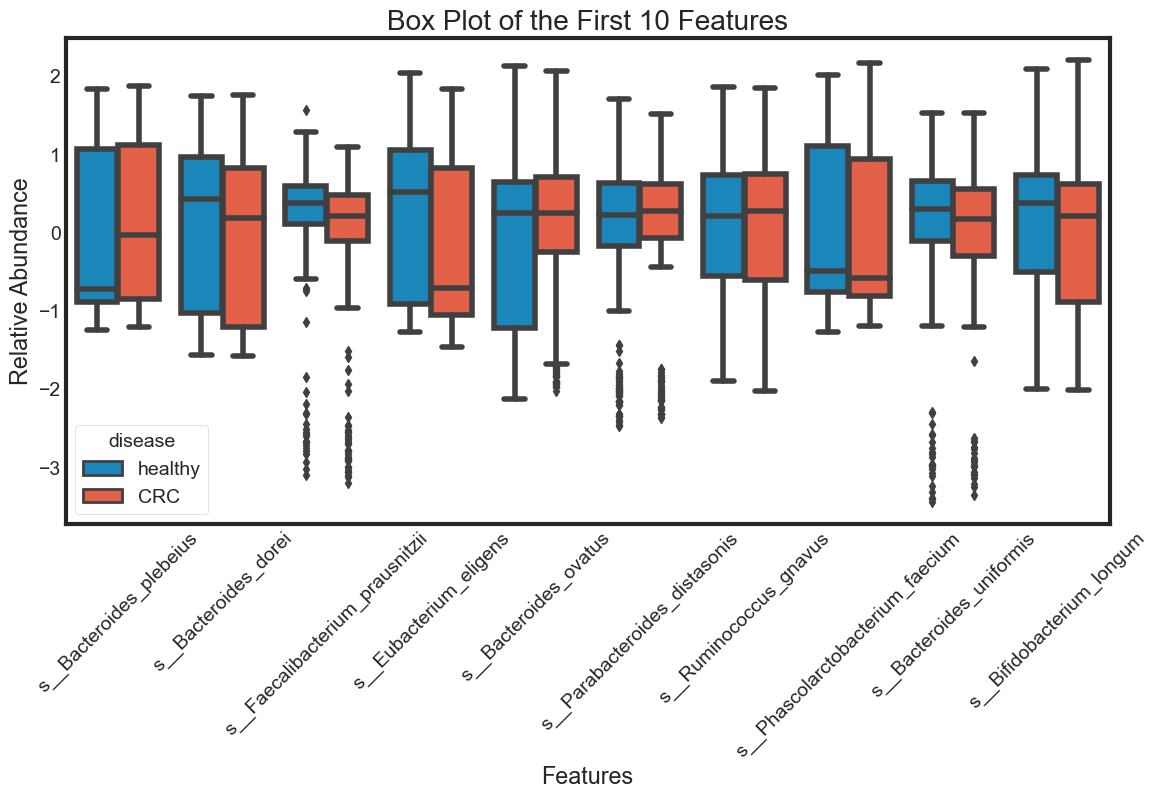

In [12]:
def box_plot(features, name):
    """
    This function creates box plots of features given in the argument.
    """
    # Create query
    query = ''
    for x in features:
        query += "features == '" + str(x) + "' or "
    query = query[0:-4]

    # Create data for visualization
    data = data_scaled_melt.query(query)

    # Plot figure
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='features', 
                y='value', 
                hue='disease', 
                data=data)
    plt.xticks(rotation=45)
    plt.title(name)
    plt.xlabel("Features")
    plt.ylabel("Relative Abundance")

box_plot(data.columns[1:11], "Box Plot of the First 10 Features")

The violin plot is very efficient in comparing distributions of different variables. The classification becomes clear in the swarm plot. Finally, the box plots are useful in comparing median and detecing outliers.

From above plots we can draw some insights from the data:

+ The median of some features are very different between 'healthy' and 'CRC'. This seperation can be seen clearly in the box plots. They can be very good features for classification. For examples: *s__Faecalibacterium_prausnitzii*.

+ However, there are distributions looking similar between 'healthy' and 'CRC'. For examples: *s__Bacteroides_plebeius*. These features are weak in classifying data.

+ Some features have similar distributions, thus might be highly correlated with each other. We should not include all these hightly correlated varibles in our predicting model.

## Correlation

As discussed above, some dependent variables in the dataset might be highly correlated with each other. Let's explore the correlation of three examples above.

In [13]:
def correlation(data_frame, var):
    """
    1. Print correlation
    2. Create jointplot
    """
    # Print correlation
    print("Correlation: ", data_frame[[var[0], var[1]]].corr().iloc[1, 0])

    # Create jointplot
    plt.figure(figsize=(6, 6))
    sns.jointplot(data = data_frame,
                  x = var[0], 
                  y = var[1], 
                  kind='reg')

<Figure size 600x600 with 0 Axes>

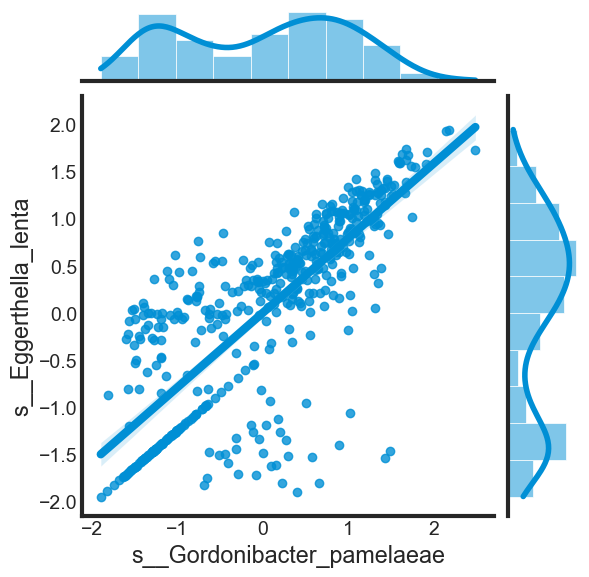

In [14]:
%%capture --no-display
correlation(data_scaled, ['s__Gordonibacter_pamelaeae', 's__Eggerthella_lenta'])

<AxesSubplot: >

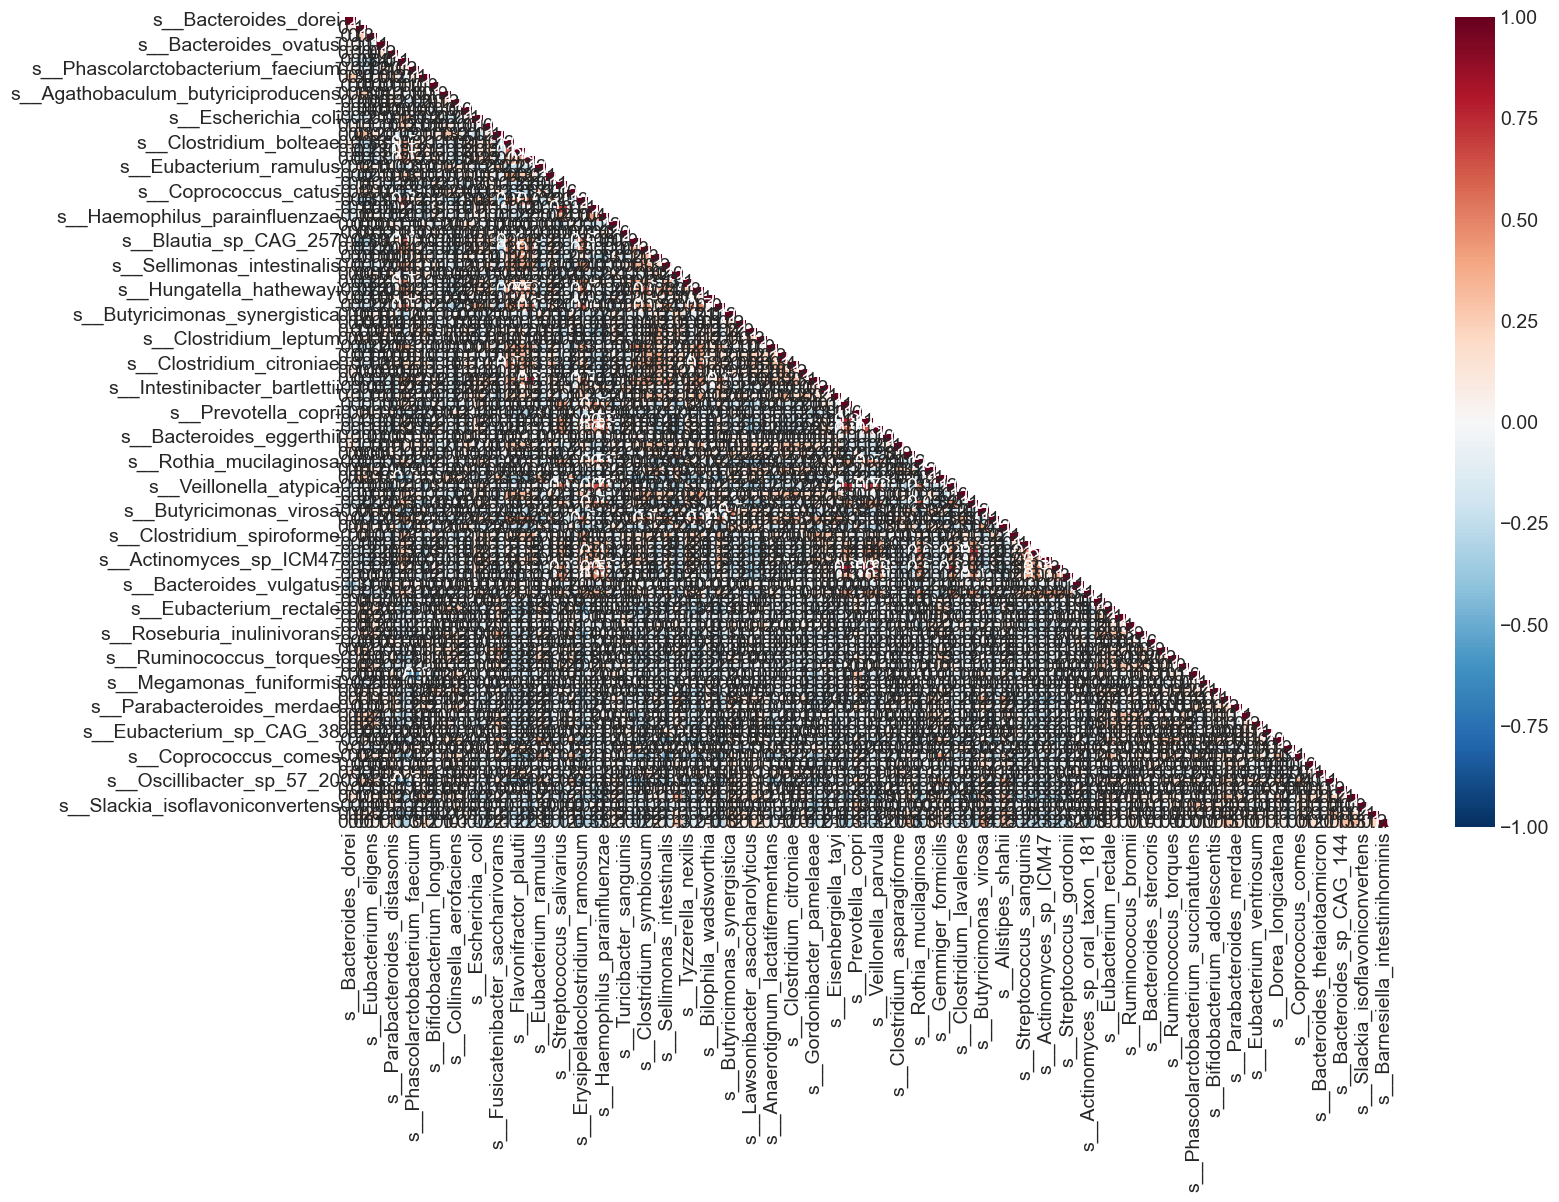

In [17]:
%%capture --no-display

# Create correlation matrix
corr_mat = data_scaled.iloc[:, 1:100].corr()

# Create mask
mask = np.zeros_like(corr_mat, dtype=np.bool)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_mat, 
            annot=True, 
            fmt='.1f',
            cmap='RdBu_r', 
            vmin=-1, 
            vmax=1,
            mask=mask)

From the heat map, we can see that many variables in the dataset are highly correlated. What are variables having correlation greater than 0.5?

<AxesSubplot: >

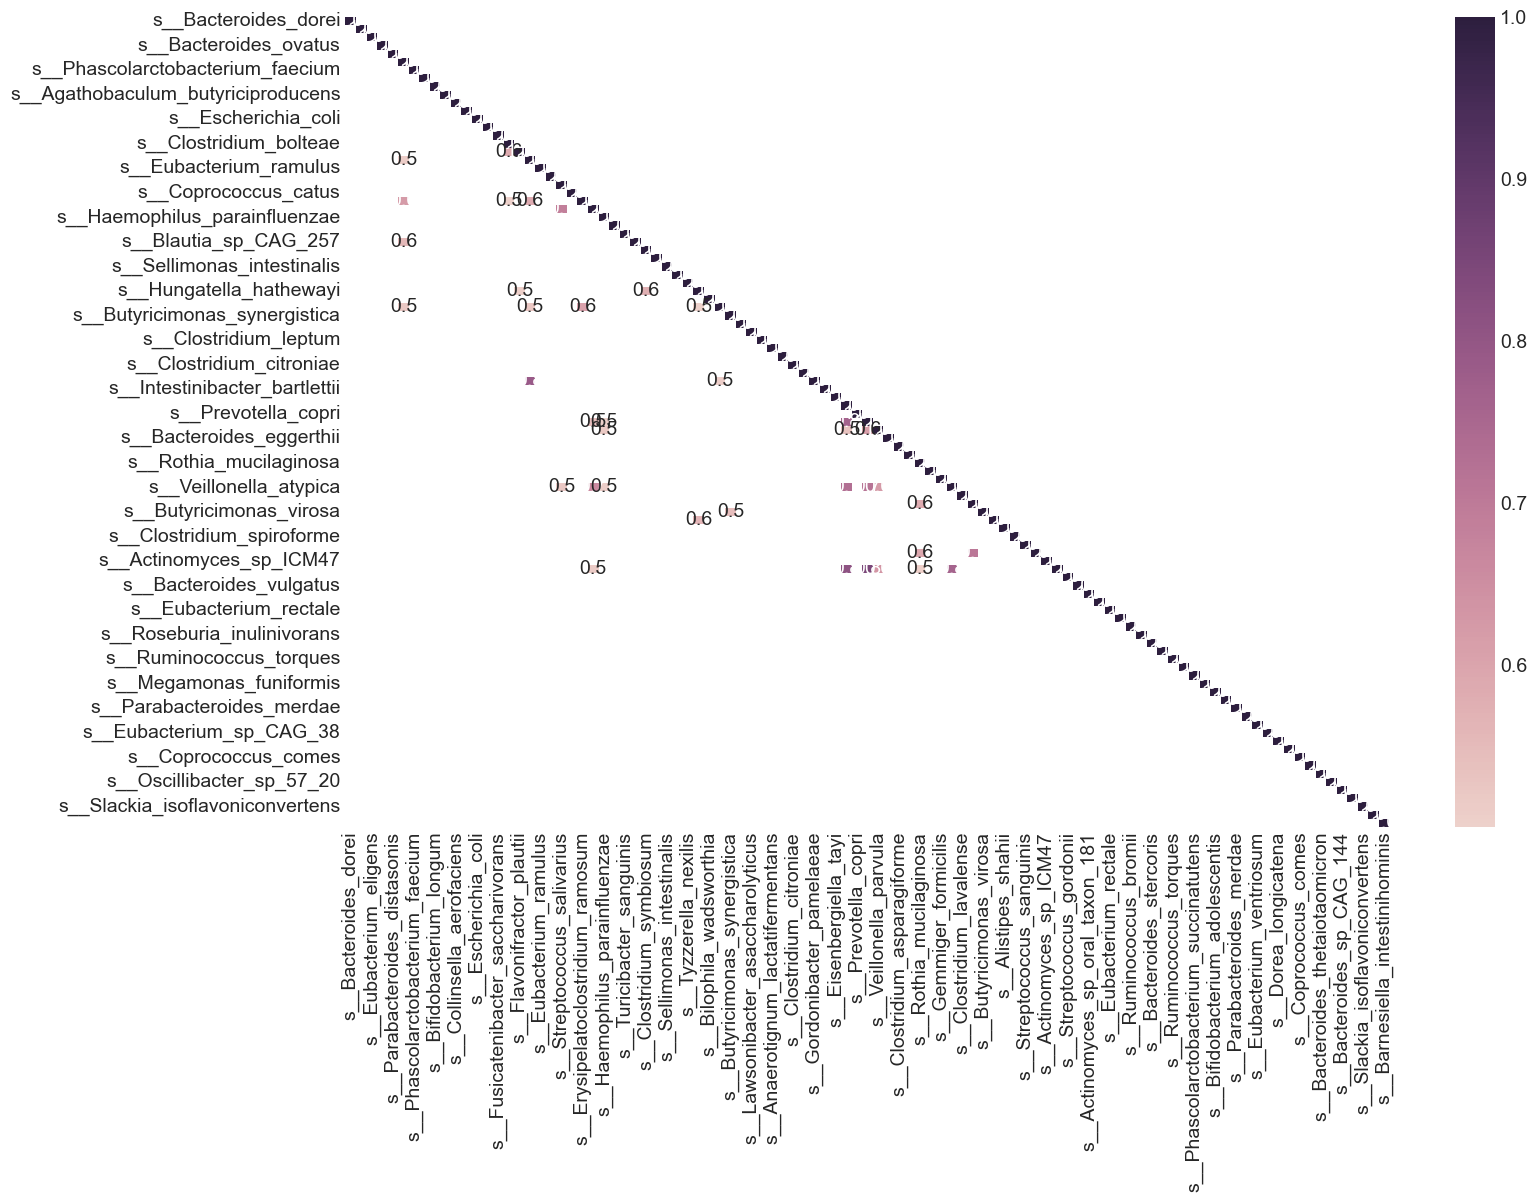

In [18]:
plt.figure(figsize=(15, 10))
sns.heatmap(corr_mat[corr_mat > 0.5], 
            annot=True,
            fmt='.1f', 
            cmap=sns.cubehelix_palette(200), 
            mask=mask)

## Feature Selection 

Using Univariate Feature Selection [(sklearn.feature_selection.SelectKBest)](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest) to choose N features with the k highest scores.

In [19]:
from sklearn.feature_selection import SelectKBest, f_classif

df_features = data.iloc[:, 1:]
df_disease = data['disease']

feature_selection = SelectKBest(f_classif, k=100).fit(df_features, df_disease)
selected_features = df_features.columns[feature_selection.get_support()]
print("The N selected features are: ", list(selected_features))

The N selected features are:  ['s__Bacteroides_plebeius', 's__Bacteroides_dorei', 's__Faecalibacterium_prausnitzii', 's__Eubacterium_eligens', 's__Bacteroides_ovatus', 's__Parabacteroides_distasonis', 's__Phascolarctobacterium_faecium', 's__Bacteroides_uniformis', 's__Bifidobacterium_longum', 's__Collinsella_aerofaciens', 's__Clostridium_sp_CAG_58', 's__Blautia_wexlerae', 's__Fusicatenibacter_saccharivorans', 's__Eggerthella_lenta', 's__Clostridium_bolteae_CAG_59', 's__Streptococcus_salivarius', 's__Coprococcus_catus', 's__Erysipelatoclostridium_ramosum', 's__Haemophilus_parainfluenzae', 's__Holdemania_filiformis', 's__Turicibacter_sanguinis', 's__Clostridium_symbiosum', 's__Ruthenibacterium_lactatiformans', 's__Sellimonas_intestinalis', 's__Bilophila_wadsworthia', 's__Butyricimonas_synergistica', 's__Parabacteroides_goldsteinii', 's__Anaerotignum_lactatifermentans', 's__Anaerotruncus_colihominis', 's__Intestinibacter_bartlettii', 's__Eisenbergiella_tayi', 's__Prevotella_copri', 's__Cl

In [20]:
data_selected = pd.DataFrame(feature_selection.transform(df_features),
                 columns=selected_features)
data_selected.head()

s__Bacteroides_plebeius  s__Bacteroides_dorei  \
0                10.262146              8.532694   
1                 7.609333              4.466872   
2                 8.411267              7.884081   
3                 6.261269              6.939669   
4                -0.026692              5.697435   

   s__Faecalibacterium_prausnitzii  s__Eubacterium_eligens  \
0                         7.729839                7.605931   
1                         6.654823                4.236672   
2                         7.668467               -3.379905   
3                         5.819509                4.064784   
4                         3.808831                4.253082   

   s__Bacteroides_ovatus  s__Parabacteroides_distasonis  \
0               7.477464                       7.267232   
1               4.697277                       3.518645   
2               6.577229                       6.474488   
3               4.026179                       7.227381   
4               4.284986                       5.784833   

   s__Phascolarctobacterium_faecium  s__Bacteroides_uniformis  \
0                          6.832596                  6.738413   
1                         -3.929140                  5.619399   
2                         -3.379905                  6.725545   
3                         -3.632294                  6.170285   
4                         -5.007660                  5.492187   

   s__Bifidobacterium_longum  s__Collinsella_aerofaciens  ...  \
0                   6.717971                    6.576766  ...   
1                   4.429797                    4.532923  ...   
2                  -3.379905                   -3.379905  ...   
3                   3.089479                    5.897842  ...   
4                   3.893588                    4.759592  ...   

   s__Fusobacterium_mortiferum  s__Bifidobacterium_dentium  \
0                    -3.441779                   -3.441779   
1                    -3.929140                   -3.929140   
2                    -3.379905                   -3.379905   
3                     3.295942                    1.107104   
4                    -5.007660                   -5.007660   

   s__Bacteroides_finegoldii  s__Clostridium_saccharolyticum  \
0                  -3.441779                       -3.441779   
1                  -3.929140                       -3.929140   
2                  -3.379905                       -3.379905   
3                  -3.632294                       -3.632294   
4                   4.187313                        2.219946   

   s__Streptococcus_anginosus_group  s__Streptococcus_sp_A12  \
0                         -3.441779                -3.441779   
1                         -3.929140                -3.929140   
2                         -3.379905                -3.379905   
3                         -3.632294                -3.632294   
4                          0.713786                -5.007660   

   s__Bacteroides_coprocola  s__Ruminococcus_lactaris  s__Turicimonas_muris  \
0                 -3.441779                 -3.441779             -3.441779   
1                 -3.929140                 -3.929140             -3.929140   
2                 -3.379905                 -3.379905             -3.379905   
3                 -3.632294                 -3.632294             -3.632294   
4                 -5.007660                 -5.007660             -5.007660   

   s__Proteobacteria_bacterium_CAG_139  
0                            -3.441779  
1                            -3.929140  
2                            -3.379905  
3                            -3.632294  
4                            -5.007660  

[5 rows x 100 columns]

To see how different these features are in 'CRC' and in 'healthy' by pairplot.

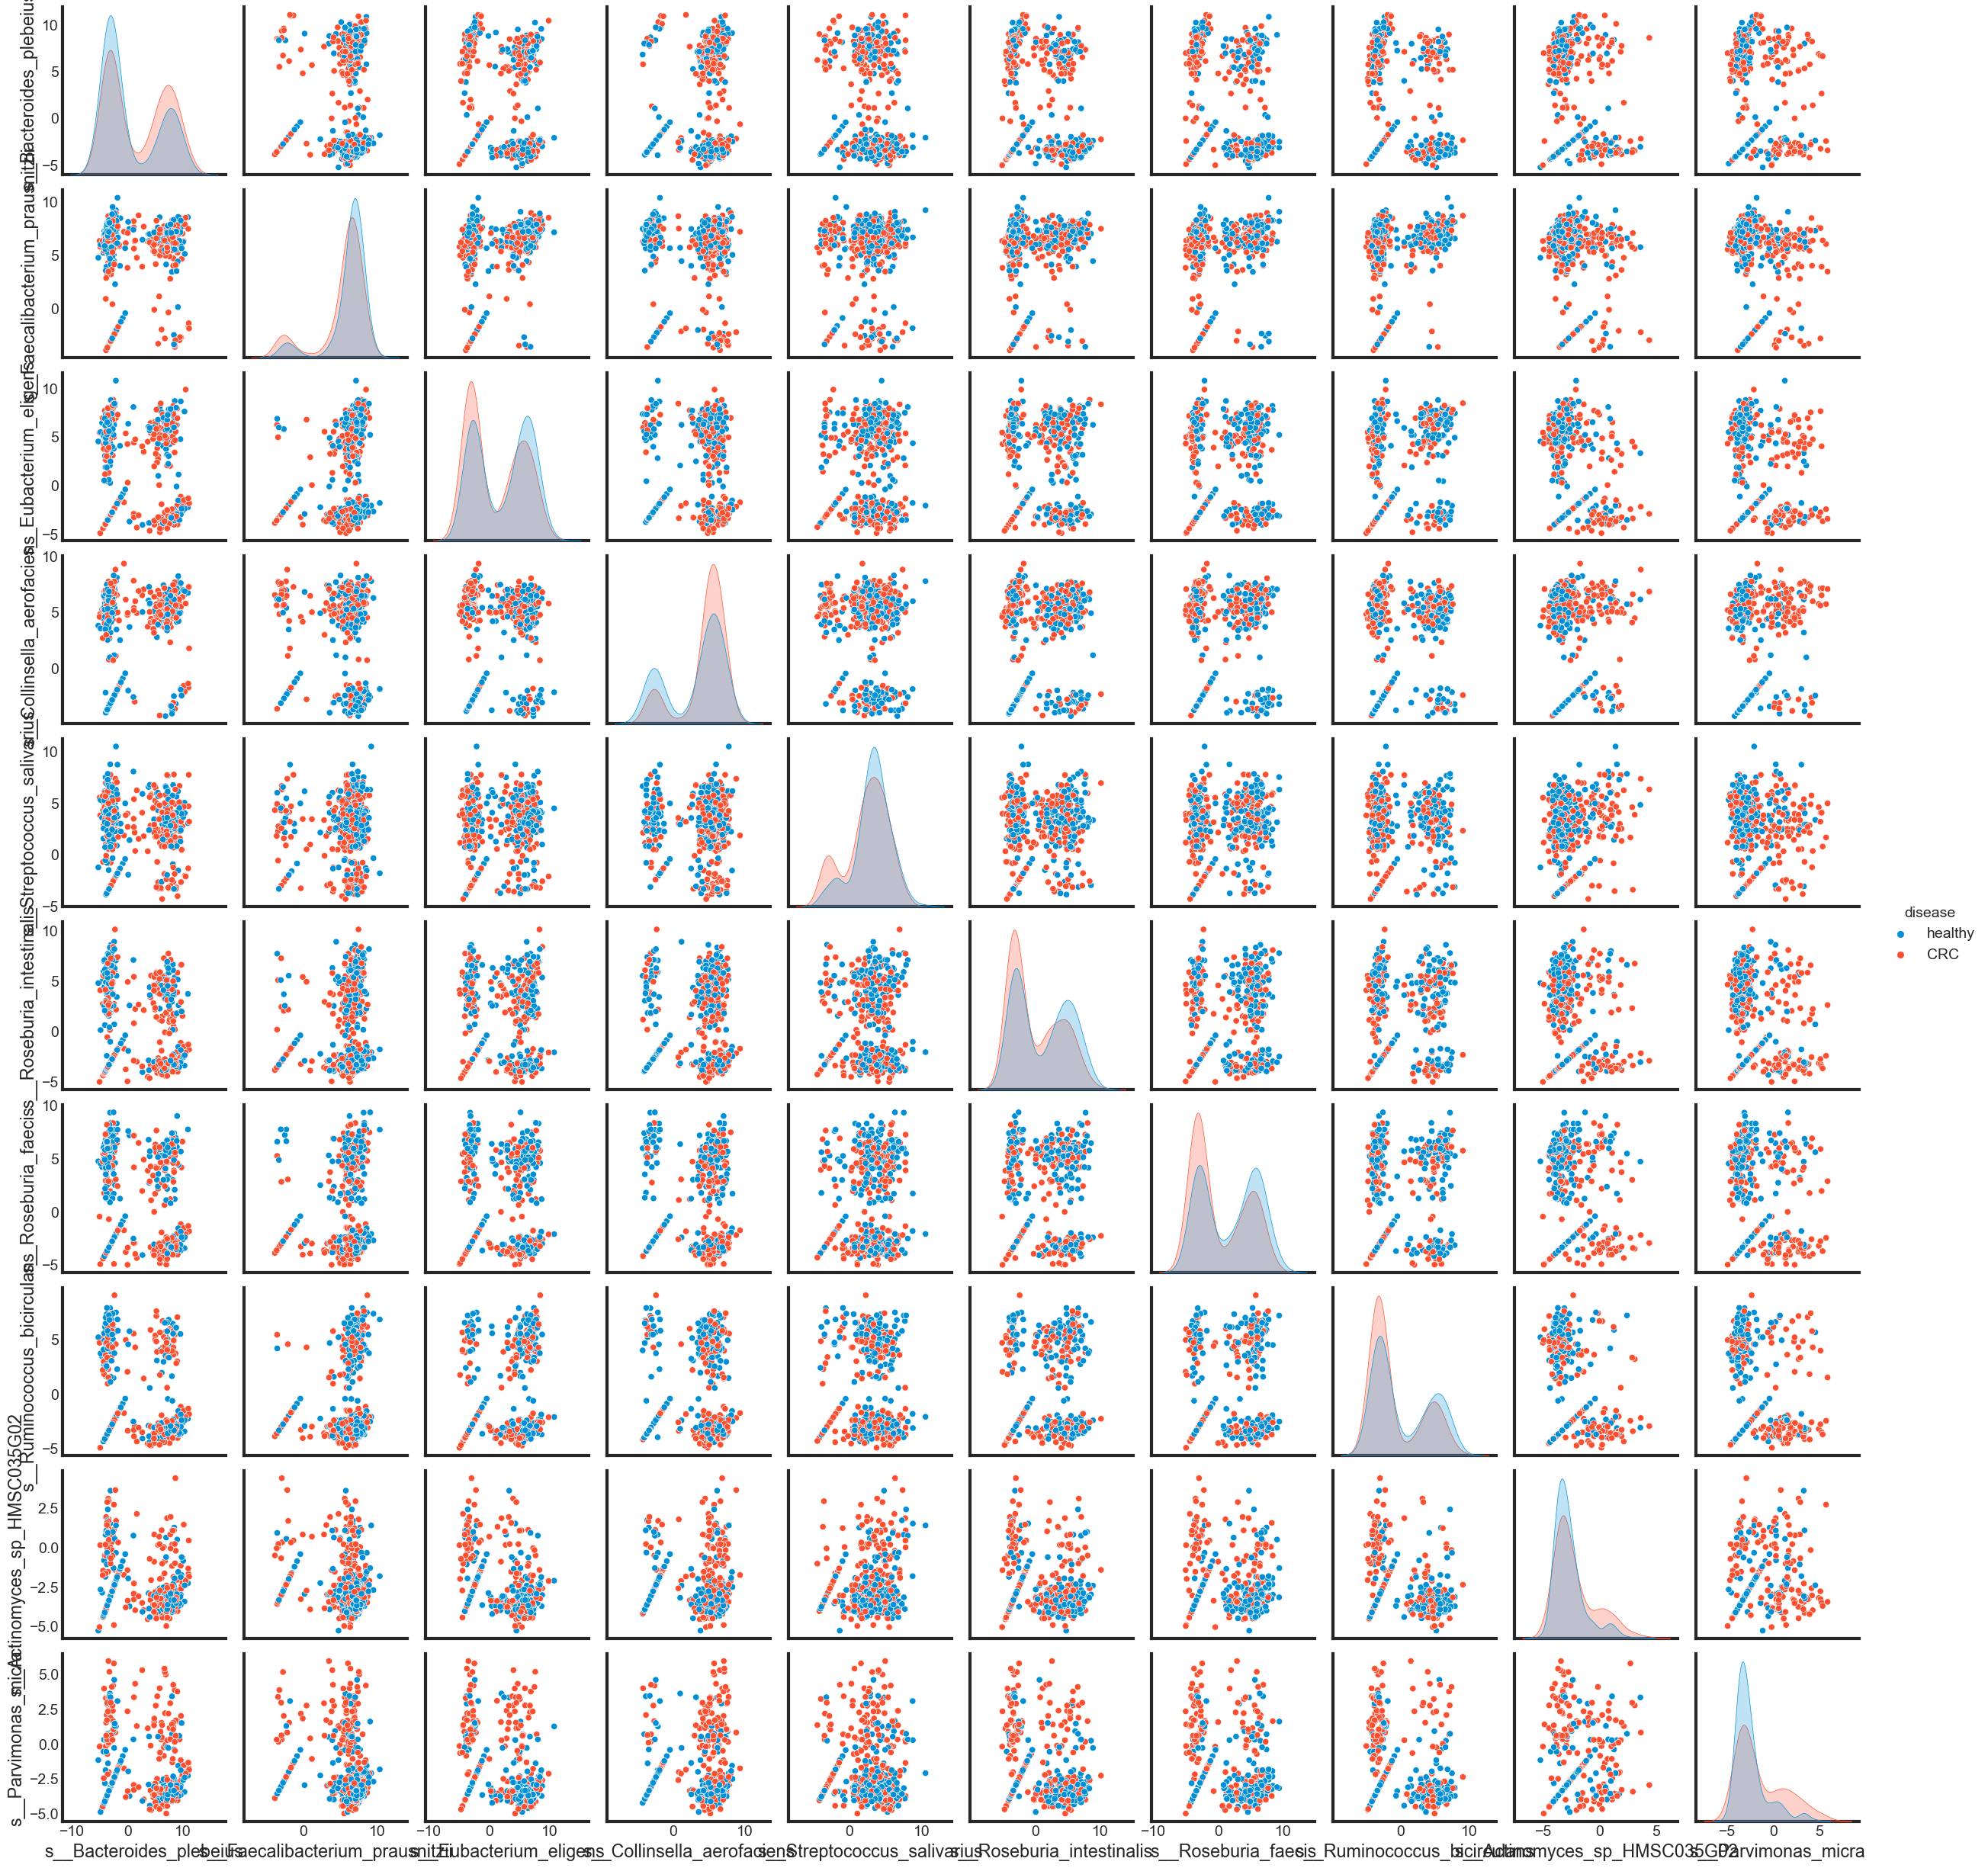

In [24]:
sns.pairplot(pd.concat([data_selected, data['disease']], axis=1), hue='disease')

## Principal component analysis

Text(0, 0.5, 'Second Principal Component')

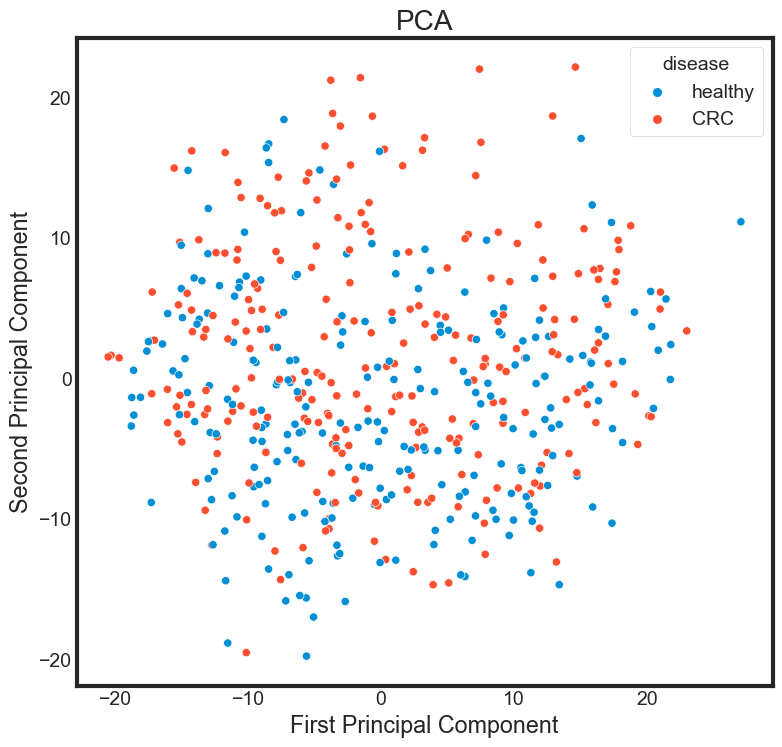

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(data_selected)
data_selected_pca = pca.transform(data_selected)

PCA_df = pd.DataFrame()
PCA_df['PCA_1'] = data_selected_pca[:, 0]
PCA_df['PCA_2'] = data_selected_pca[:, 1]


plt.figure(figsize=(8, 8))
sns.scatterplot(data = PCA_df,
                x = 'PCA_1', 
                y = 'PCA_2',
                hue=data['disease'])
plt.title("PCA")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")

## Transforming the string label into numeric lable

The RandomForestClassifier in sklearn does not accept string labels for categorical variables.

+ 0 = Healthy = Healthy Control
+ 1 = CRC = Colorectal Cancer

In [22]:
data['disease'] = data['disease'].map({'healthy':0, 'CRC':1})
data.head(n=6)

disease  s__Bacteroides_plebeius  s__Bacteroides_dorei  \
0        0                10.262146              8.532694   
1        0                 7.609333              4.466872   
2        0                 8.411267              7.884081   
3        0                 6.261269              6.939669   
4        1                -0.026692              5.697435   
5        1                -0.655056             -1.760058   

   s__Faecalibacterium_prausnitzii  s__Eubacterium_eligens  \
0                         7.729839                7.605931   
1                         6.654823                4.236672   
2                         7.668467               -3.379905   
3                         5.819509                4.064784   
4                         3.808831                4.253082   
5                         7.171883               -1.760058   

   s__Bacteroides_ovatus  s__Parabacteroides_distasonis  \
0               7.477464                       7.267232   
1               4.697277                       3.518645   
2               6.577229                       6.474488   
3               4.026179                       7.227381   
4               4.284986                       5.784833   
5               0.737587                       7.421635   

   s__Ruminococcus_gnavus  s__Phascolarctobacterium_faecium  \
0                7.074996                          6.832596   
1                2.603642                         -3.929140   
2                6.883446                         -3.379905   
3                3.407265                         -3.632294   
4                6.384592                         -5.007660   
5                7.857269                          6.762199   

   s__Bacteroides_uniformis  ...  s__Bacteroides_finegoldii  \
0                  6.738413  ...                  -3.441779   
1                  5.619399  ...                  -3.929140   
2                  6.725545  ...                  -3.379905   
3                  6.170285  ...                  -3.632294   
4                  5.492187  ...                   4.187313   
5                  3.025669  ...                  -1.760058   

   s__Haemophilus_sp_HMSC71H05  s__Clostridium_saccharolyticum  \
0                    -3.441779                       -3.441779   
1                    -3.929140                       -3.929140   
2                    -3.379905                       -3.379905   
3                    -3.632294                       -3.632294   
4                     2.872359                        2.219946   
5                    -1.760058                        2.682819   

   s__Streptococcus_anginosus_group  s__Streptococcus_sp_A12  \
0                         -3.441779                -3.441779   
1                         -3.929140                -3.929140   
2                         -3.379905                -3.379905   
3                         -3.632294                -3.632294   
4                          0.713786                -5.007660   
5                         -1.760058                -0.364194   

   s__Klebsiella_pneumoniae  s__Bacteroides_coprocola  \
0                 -3.441779                 -3.441779   
1                 -3.929140                 -3.929140   
2                 -3.379905                 -3.379905   
3                 -3.632294                 -3.632294   
4                 -5.007660                 -5.007660   
5                 -1.760058                 -1.760058   

   s__Ruminococcus_lactaris  s__Turicimonas_muris  \
0                 -3.441779             -3.441779   
1                 -3.929140             -3.929140   
2                 -3.379905             -3.379905   
3                 -3.632294             -3.632294   
4                 -5.007660             -5.007660   
5                 -1.760058             -1.760058   

   s__Proteobacteria_bacterium_CAG_139  
0                            -3.441779  
1                            -3.929140  
2                            -3.379

## Creating Train and Test Sets

In [23]:
X = data_selected
Y = data['disease']

x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size = 0.30, random_state = 42)
# Cleaning test sets to avoid future warning messages
y_train = y_train.values.ravel() 
y_test = y_test.values.ravel()  

## Fitting Random Forest

+ **n_estimators**: The number of decision tree
+ **max_depth**: The maximum splits for all trees in the forest. 
+ **bootstrap**: An indicator of whether or not we want to use bootstrap samples when building trees.
+ **max_features**: The maximum number of features that will be used in node splitting.
+ **criterion**: This is the metric used to asses the stopping criteria for the decision trees.

In [24]:
#%%capture --no-display

fit_rfc = RandomForestClassifier(random_state=123)

np.random.seed(123)
start = time.time()

# hyperparameters Optimzation
param_grid = {
        'n_estimators': [200, 500],
        'max_features': ['auto', 'sqrt', 'log2', None],
        'bootstrap': [True, False],
        'max_depth': [2, 3, 4, 5, 6],
        'criterion': ['gini', 'entropy', 'log_loss']
}

# tuning parameters
cv_rfc = GridSearchCV(estimator = fit_rfc,
                      param_grid=param_grid,
                      cv=5,
                      n_jobs=3)
cv_rfc.fit(X=x_train, y=y_train)

print('Best Parameters using grid search: \n', cv_rfc.best_params_)

end = time.time()

print('Time taken in grid search: {0: .2f}'.format(end - start))

/Users/zouhua/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
400 fits failed out of a total of 1200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zouhua/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zouhua/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/Users/zouhua/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator

Best Parameters using grid search: 
 {'bootstrap': False, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 200}
Time taken in grid search:  273.51


In [27]:
fit_rfc.set_params(bootstrap = True,
                   criterion = 'gini',
                   max_features = 'auto',
                   max_depth = 4,
                   n_estimators = 200)

RandomForestClassifier(max_depth=4, n_estimators=200, oob_score=True,
                       random_state=123, warm_start=True)

## Out of Bag Error Rate

> Another useful feature of random forest is the concept of an out-of-bag (OOB) error rate. Because only two-thirds of the data are used to train each tree when building the forest, one-third of unseen data can be used in a way that is advantageous to our accuracy metrics without being as computationally expensive as something like cross validation, for instance.

Text(0.5, 1.0, 'OOB Error Rate Across various Forest sizes \n(From 15 to 1000 trees)')

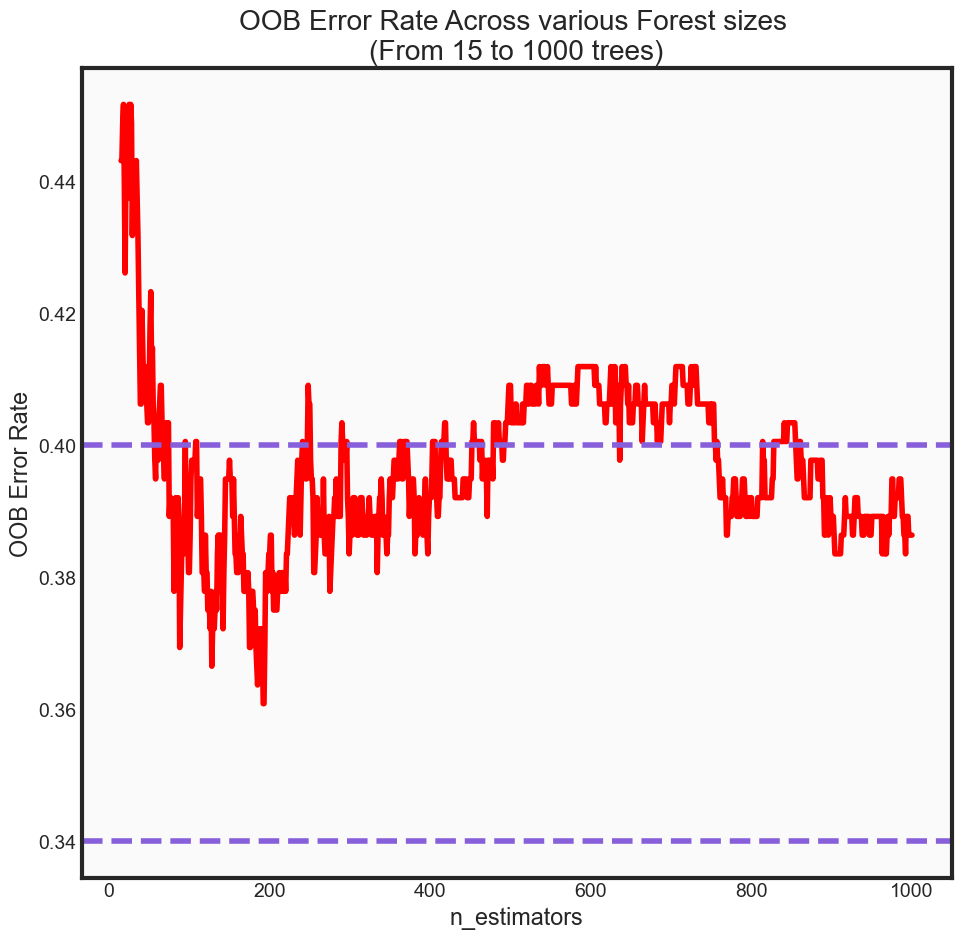

In [28]:
%%capture --no-display

fit_rfc.set_params(warm_start=True, 
                   oob_score=True)

min_estimators = 15
max_estimators = 1000

error_rate = {}

for i in range(min_estimators, max_estimators + 1):
    fit_rfc.set_params(n_estimators = i)
    fit_rfc.fit(x_train, y_train)
    
    oob_error = 1 - fit_rfc.oob_score_
    error_rate[i] = oob_error

oob_series = pd.Series(error_rate)

fig, ax = plt.subplots(figsize=(10, 10))

ax.set_facecolor('#fafafa')

oob_series.plot(kind='line',
                color = 'red')
plt.axhline(0.4, 
            color='#875FDB',
            linestyle='--')
plt.axhline(0.34, 
            color='#875FDB',
            linestyle='--')
plt.xlabel('n_estimators')
plt.ylabel('OOB Error Rate')
plt.title('OOB Error Rate Across various Forest sizes \n(From 15 to 1000 trees)')

In [29]:
print('OOB Error rate for 200 trees is: {0:.5f}'.format(oob_series[200]))

OOB Error rate for 200 trees is: 0.38352


## Building model of optimal parameters 

In [30]:
rfc_final = RandomForestClassifier(bootstrap = True,
                                   criterion = 'gini',
                                   max_features = 'auto',
                                   max_depth = 4,
                                   n_estimators = 200, 
                                   random_state = 123)
rfc_final.fit(x_train, y_train)

classifier_score = rfc_final.score(x_train, y_train)
print('\nThe classifier accuracy score is {:03.2f}\n'.format(classifier_score))


The classifier accuracy score is 0.95



### The performance of model on testData

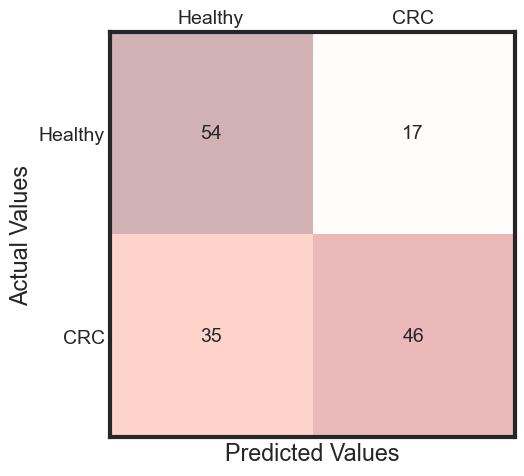

In [31]:
%%capture --no-display

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image, display
from sklearn import metrics, preprocessing

predicted = rfc_final.predict(x_test)
accuracy = accuracy_score(y_test, predicted)

cm = metrics.confusion_matrix(y_test, predicted)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Reds, alpha=0.3)
for i in range(cm.shape[0]):
     for j in range(cm.shape[1]):
         ax.text(x=j, y=i,
                s=cm[i, j], 
                va='center', ha='center')
plt.xlabel('Predicted Values', )
plt.ylabel('Actual Values')

ax.set_xticklabels([''] + ['Healthy', "CRC"])
ax.set_yticklabels([''] + ['Healthy', "CRC"])

plt.show()

## ROC Curve Metrics

In [32]:
# We grab the second array from the output which corresponds to
# to the predicted probabilites of positive classes 
# Ordered wrt fit.classes_ in our case [0, 1] where 1 is our positive class
predictions_prob = rfc_final.predict_proba(x_test)[:, 1]

fpr2, tpr2, _ = roc_curve(y_test,
                          predictions_prob,
                          pos_label = 1)

auc_rf = auc(fpr2, tpr2)

print("The AUC for model is: {0: .4f}" .format(auc_rf))

The AUC for model is:  0.6653


/var/folders/82/kf2cy4v112b374jb5xcvmwh40000gn/T/ipykernel_1826/1087969157.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 0], [1, 0], 'k--', lw=2, color = 'black')
/var/folders/82/kf2cy4v112b374jb5xcvmwh40000gn/T/ipykernel_1826/1087969157.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([1, 0], [1, 1], 'k--', lw=2, color = 'black')


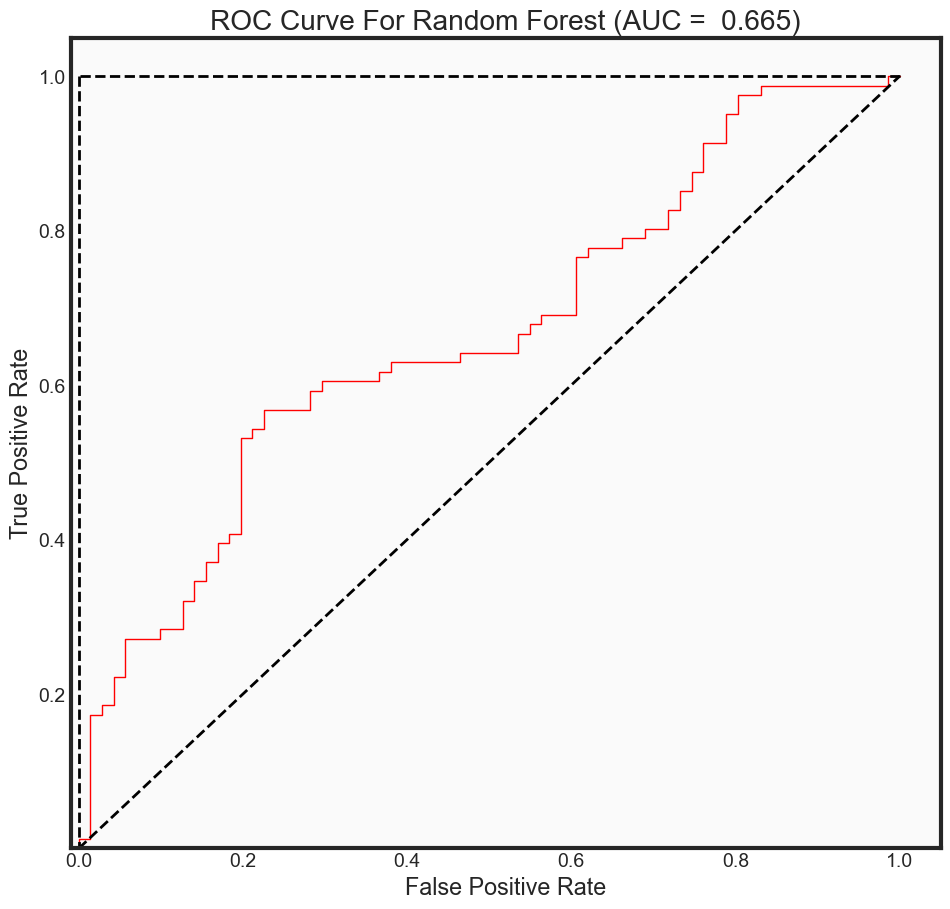

In [33]:
def plot_roc_curve(fpr, tpr, auc, estimator, xlim=None, ylim=None):
    """
    Purpose
    ----------
    Function creates ROC Curve for respective model given selected parameters.
    Optional x and y limits to zoom into graph

    Parameters
    ----------
    * fpr: Array returned from sklearn.metrics.roc_curve for increasing
            false positive rates
    * tpr: Array returned from sklearn.metrics.roc_curve for increasing
            true positive rates
    * auc: Float returned from sklearn.metrics.auc (Area under Curve)
    * estimator: String represenation of appropriate model, can only contain the
    following: ['knn', 'rf', 'nn']
    * xlim: Set upper and lower x-limits
    * ylim: Set upper and lower y-limits
    """
    my_estimators = {'knn': ['Kth Nearest Neighbor', 'deeppink'],
              'rf': ['Random Forest', 'red'],
              'nn': ['Neural Network', 'purple']}

    try:
        plot_title = my_estimators[estimator][0]
        color_value = my_estimators[estimator][1]
    except KeyError as e:
        print("'{0}' does not correspond with the appropriate key inside the estimators dictionary. \
\nPlease refer to function to check `my_estimators` dictionary.".format(estimator))
        raise

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_facecolor('#fafafa')

    plt.plot(fpr, tpr,
             color=color_value,
             linewidth=1)
    plt.title('ROC Curve For {0} (AUC = {1: 0.3f})'\
              .format(plot_title, auc))

    plt.plot([0, 1], [0, 1], 'k--', lw=2) # Add Diagonal line
    plt.plot([0, 0], [1, 0], 'k--', lw=2, color = 'black')
    plt.plot([1, 0], [1, 1], 'k--', lw=2, color = 'black')
    if xlim is not None:
        plt.xlim(*xlim)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    plt.close()

plot_roc_curve(fpr2, tpr2, auc_rf, 'rf',
               xlim=(-0.01, 1.05), 
               ylim=(0.001, 1.05))

## Classification Report

In [34]:
def print_class_report(predictions, alg_name):
    """
    Purpose
    ----------
    Function helps automate the report generated by the
    sklearn package. Useful for multiple model comparison

    Parameters:
    ----------
    predictions: The predictions made by the algorithm used
    alg_name: String containing the name of the algorithm used
    
    Returns:
    ----------
    Returns classification report generated from sklearn. 
    """
    print('Classification Report for {0}:'.format(alg_name))
    print(classification_report(predictions, 
            y_test, 
            target_names = dx))

dx = ['Healthy', "CRC"]

class_report = print_class_report(predicted, 'Random Forest')

Classification Report for Random Forest:
              precision    recall  f1-score   support

     Healthy       0.76      0.61      0.68        89
         CRC       0.57      0.73      0.64        63

    accuracy                           0.66       152
   macro avg       0.66      0.67      0.66       152
weighted avg       0.68      0.66      0.66       152



## Feature Importance

Until now, I have used all the features given in the model. Now, I will select only the important features, build the model using these features and see its effect on accuracy.

In [35]:
feature_scores = pd.Series(rfc_final.feature_importances_, 
                           index=x_train.columns,
                           name='Importance').sort_values(ascending=False)

feature_scores

s__Roseburia_faecis                    0.054408
s__Parvimonas_micra                    0.038683
s__Collinsella_aerofaciens             0.028716
s__Bacteroides_cellulosilyticus        0.022687
s__Proteobacteria_bacterium_CAG_139    0.021398
                                         ...   
s__Clostridium_symbiosum               0.003134
s__Bacteroides_uniformis               0.003102
s__Bacteroides_coprocola               0.002990
s__Megamonas_hypermegale               0.002715
s__Alistipes_indistinctus              0.002612
Name: Importance, Length: 100, dtype: float64

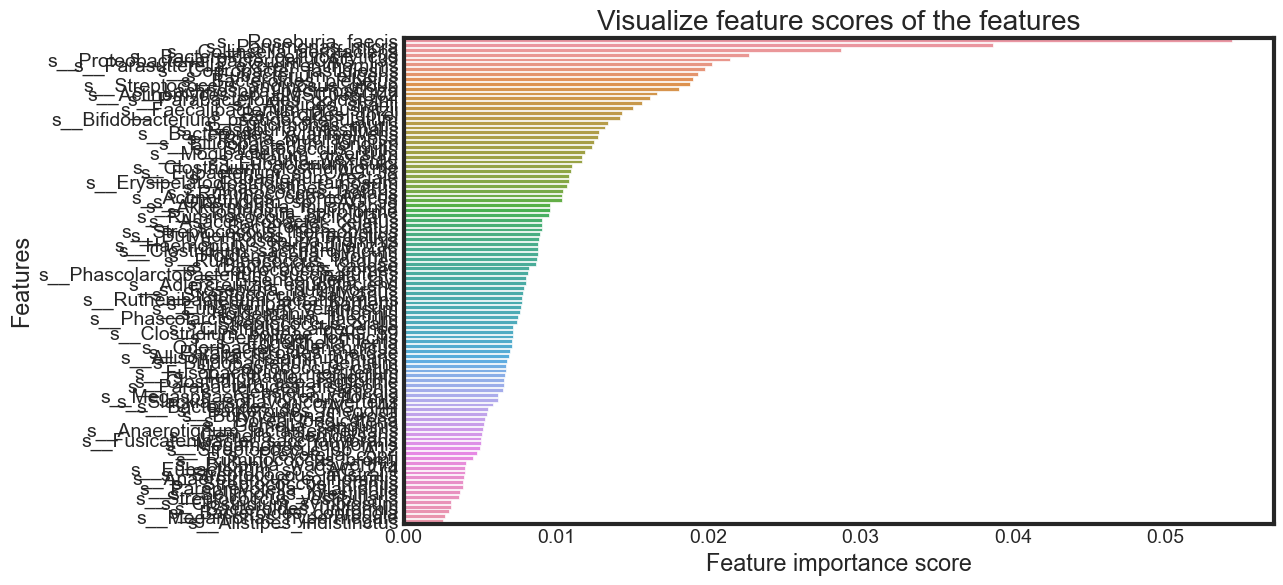

In [36]:
f, ax = plt.subplots(figsize=(10, 6))
ax = sns.barplot(x=feature_scores, y=feature_scores.index)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

### Selecting features by importance 



In [37]:
feature_scores.to_frame()

Importance
s__Roseburia_faecis                    0.054408
s__Parvimonas_micra                    0.038683
s__Collinsella_aerofaciens             0.028716
s__Bacteroides_cellulosilyticus        0.022687
s__Proteobacteria_bacterium_CAG_139    0.021398
...                                         ...
s__Clostridium_symbiosum               0.003134
s__Bacteroides_uniformis               0.003102
s__Bacteroides_coprocola               0.002990
s__Megamonas_hypermegale               0.002715
s__Alistipes_indistinctus              0.002612

[100 rows x 1 columns]

In [47]:
selected_features_imp = feature_scores.to_frame()
selected_features_imp = selected_features_imp[selected_features_imp['Importance'] > 0.01]
selected_features_imp

Importance
s__Roseburia_faecis                     0.054408
s__Parvimonas_micra                     0.038683
s__Collinsella_aerofaciens              0.028716
s__Bacteroides_cellulosilyticus         0.022687
s__Proteobacteria_bacterium_CAG_139     0.021398
s__Parasutterella_excrementihominis     0.020249
s__Coprobacter_fastidiosus              0.019776
s__Eubacterium_eligens                  0.019302
s__Bacteroides_plebeius                 0.019007
s__Streptococcus_anginosus_group        0.018813
s__Lachnospira_pectinoschiza            0.018070
s__Actinomyces_sp_HMSC035G02            0.016633
s__Parabacteroides_goldsteinii          0.016162
s__Alistipes_shahii                     0.015669
s__Faecalibacterium_prausnitzii         0.015090
s__Bacteroides_dorei                    0.014330
s__Bifidobacterium_pseudocatenulatum    0.014211
s__Turicimonas_muris                    0.013414
s__Roseburia_intestinalis               0.013204
s__Bacteroides_xylanisolvens            0.012800
s__Rothia_mucilaginosa                  0.012791
s__Bifidobacterium_longum               0.012468
s__Streptococcus_mitis                  0.012383
s__Mogibacterium_diversum               0.011902
s__Blautia_wexlerae                     0.011741
s__Eubacterium_sulci                    0.011740
s__Clostridium_clostridioforme          0.011074
s__Eubacterium_sp_CAG_38                0.011013
s__Eubacterium_rectale                  0.010855
s__Erysipelatoclostridium_ramosum       0.010849
s__Anaerostipes_hadrus                  0.010746
s__Ruminococcus_lactaris                0.010473
s__Actinomyces_odontolyticus            0.010403
s__Clostridium_sp_CAG_58                0.010365

## Rebuilding model

Using the selected features to rebuild the model

In [48]:
# dataset
X_rebuild = data_selected[selected_features_imp.index.to_list()]
Y = data['disease']

# data splition
x_train, x_test, y_train, y_test = train_test_split(
    X_rebuild, Y, test_size = 0.30, random_state = 42)
## Cleaning test sets to avoid future warning messages
y_train = y_train.values.ravel() 
y_test = y_test.values.ravel()

# build model
rfc_rebuild = RandomForestClassifier(bootstrap = True,
                                     criterion = 'gini',
                                     max_features = 'auto',
                                     max_depth = 4,
                                     n_estimators = 200, 
                                     random_state = 123)
rfc_rebuild.fit(x_train, y_train)

classifier_score_rebuild = rfc_rebuild.score(x_train, y_train)
print('\nThe classifier accuracy score is {:03.2f}\n'.format(classifier_score_rebuild))

# 



The classifier accuracy score is 0.91



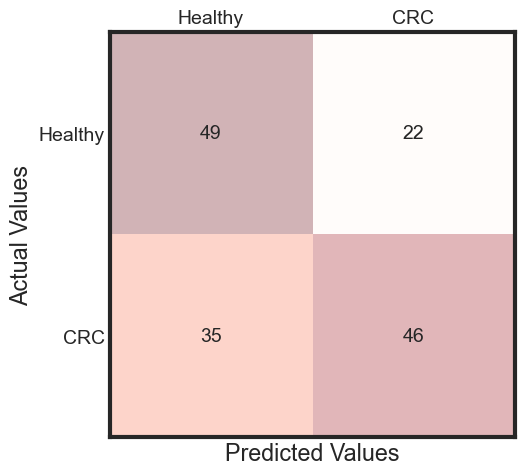

In [49]:
%%capture --no-display

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image, display
from sklearn import metrics, preprocessing

predicted = rfc_rebuild.predict(x_test)
accuracy = accuracy_score(y_test, predicted)

cm = metrics.confusion_matrix(y_test, predicted)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Reds, alpha=0.3)
for i in range(cm.shape[0]):
     for j in range(cm.shape[1]):
         ax.text(x=j, y=i,
                s=cm[i, j], 
                va='center', ha='center')
plt.xlabel('Predicted Values', )
plt.ylabel('Actual Values')

ax.set_xticklabels([''] + ['Healthy', "CRC"])
ax.set_yticklabels([''] + ['Healthy', "CRC"])

plt.show()

The AUC for model is:  0.6792


/var/folders/82/kf2cy4v112b374jb5xcvmwh40000gn/T/ipykernel_1826/1087969157.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 0], [1, 0], 'k--', lw=2, color = 'black')
/var/folders/82/kf2cy4v112b374jb5xcvmwh40000gn/T/ipykernel_1826/1087969157.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([1, 0], [1, 1], 'k--', lw=2, color = 'black')


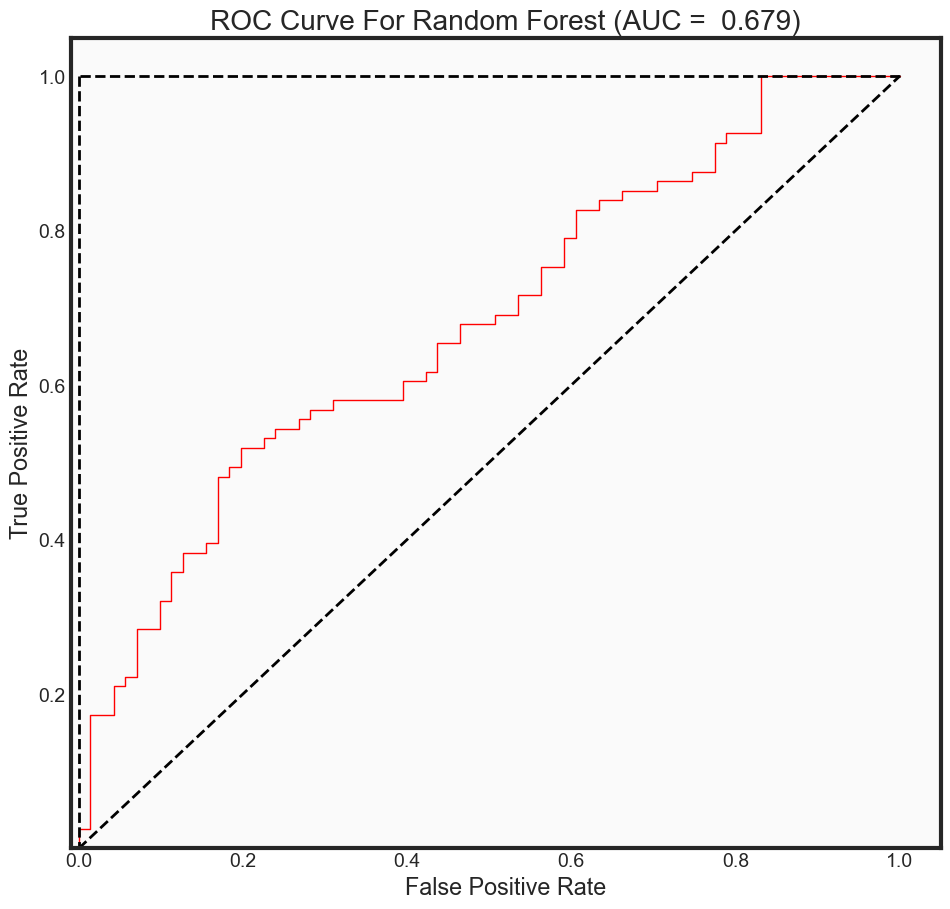

In [50]:
predictions_prob = rfc_rebuild.predict_proba(x_test)[:, 1]

fpr2, tpr2, _ = roc_curve(y_test,
                          predictions_prob,
                          pos_label = 1)

auc_rf = auc(fpr2, tpr2)

print("The AUC for model is: {0: .4f}" .format(auc_rf))

plot_roc_curve(fpr2, tpr2, auc_rf, 'rf',
               xlim=(-0.01, 1.05), 
               ylim=(0.001, 1.05))

## Summary

Worked through a classification predictive modeling machine learning problem from end-to-end using Python. Specifically, the steps covered were:
1. Problem Definition (Breast Cancer data).
2. Loading the Dataset.
3. Analyze Data (same scale but different distributions of data).
    * Evaluate Algorithms (KNN looked good).
    * Evaluate Algorithms with Standardization (KNN and SVM looked good).
4. Algorithm Tuning (K=19 for KNN was good, SVM with an RBF kernel and C=100 was best).. 
5. Finalize Model (use all training data and confirm using validation dataset)

## Reference

* [Predict Breast Cancer with Random Forest, PCA and SVM](https://github.com/chriskhanhtran/predict-breast-cancer-with-rf-pca-svm)